In [3]:
# %pip install --upgrade pip
# %pip install pandas
# %pip install numpy
# %pip install datetime
# %pip install collections
# %pip install matplotlib.pyplot
# %pip install seaborn
# %pip install pyyaml
# %pip install jsonlines
# %pip install requests
# %pip install datasets
# %pip install torch
# %pip install scikit-learn
# %pip install tabulate

# %pip install statsmodels

In [4]:
import sys
import os
import json
import pandas as pd
import numpy as np
import random
import copy
from datetime import datetime
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../")

from src.helpers import io
from src.classes.dataset import Dataset
from src.classes.annotation_set import AnnotationSet
from src.helpers.visualisation import barplot_distribution, plot_confusion_matrix, tabulate_annotation_pair_summary, analyze_pair_annotations

%load_ext autoreload
%autoreload 2

## Research Questions:

1. What is the distribution of Topics?
2. How do Topics characteristics interact with other characteristics of the text?
3. ...?


## Load Dataset + Annotations

In [5]:
# FILL IN:
PATH_TO_DATASET = "../data/automatic_annotations_v0/wildchat4k-raw.json"
DATASET_ID = "wildchat_1m"
PATH_TO_ANNOTATIONS_DIR = "../data/automatic_annotations_v0/gpto3mini-json-wildchat"

In [6]:
# Load dataset (w/o annotations)
dataset = Dataset.load(PATH_TO_DATASET)

# Load annotations into dataset
for fpath in io.listdir_nohidden(PATH_TO_ANNOTATIONS_DIR):
    annotation_set = AnnotationSet.load_automatic(path=fpath, source="automatic_v0")
    dataset.add_annotations(annotation_set)

prompt-multi_turn_relationship: 0 / 10127 failed due to invalid annotations.
prompt-interaction_features: 0 / 10127 failed due to invalid annotations.
turn-sensitive_use_flags: 20 / 10127 failed due to invalid annotations.
turn-topic: 55 / 10127 failed due to invalid annotations.
response-interaction_features: 0 / 10127 failed due to invalid annotations.
prompt-function_purpose: 103 / 10127 failed due to invalid annotations.
prompt-media_format: 9 / 10127 failed due to invalid annotations.
response-media_format: 0 / 10127 failed due to invalid annotations.
response-answer_form: 0 / 10127 failed due to invalid annotations.


## Research Question 1: What is the distribution of Topics?

In [7]:
annotation_pairs1 = dataset.get_annotation_distribution(
    "turn_topic",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
annotation_pairs2 = dataset.get_annotation_distribution(
    "turn_topic",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=False,
)

outdir = f"../data/annotation_analysis_v0/topic"
os.makedirs(outdir, exist_ok=True)
fig = barplot_distribution(
    {"Topics": annotation_pairs1}, normalize=True, 
    xlabel="Topics", ylabel="Proportion", title="",
    output_path=f"{outdir}/barchart.png", order="descending")

multibar_fig = barplot_distribution(
    {"Topics": annotation_pairs2}, normalize=True, 
    xlabel="Topics", ylabel="Proportion", title="",
    output_path=f"{outdir}/multilabel_barchart.png", order="descending")

/Users/chuanyang/Desktop/naturalistic-ai/notebooks/../src/helpers/visualisation.py:125: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')


In [8]:
# multibar_figc

In [9]:
# multibar_fig

In [10]:
print(dataset.data[0])
print(vars(dataset.data[0]))

{'conversation_id': 'wildchat_553847317a397b5def89dae32fe9defd', 'dataset_id': 'wildchat_1m', 'user_id': '8fe04885ac7d4510a0f7695261f3285dff4529ce91d15f84dc6c5880977a556a', 'time': '2023-04-25T02:20:46+00:00', 'model': 'gpt-3.5-turbo-0301', 'conversation': [<src.classes.message.Message object at 0x113545c90>, <src.classes.message.Message object at 0x11376fa90>, <src.classes.message.Message object at 0x11353f9a0>, <src.classes.message.Message object at 0x329346470>, <src.classes.message.Message object at 0x3293464d0>, <src.classes.message.Message object at 0x329346440>, <src.classes.message.Message object at 0x3293463e0>, <src.classes.message.Message object at 0x329346380>, <src.classes.message.Message object at 0x329346320>, <src.classes.message.Message object at 0x3293462c0>, <src.classes.message.Message object at 0x329346260>, <src.classes.message.Message object at 0x329346200>, <src.classes.message.Message object at 0x3293461a0>, <src.classes.message.Message object at 0x329346140>, 

In [11]:
annotation_pairs1 = dataset.get_annotation_distribution(
    "turn_topic",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
print(annotation_pairs1)

{"['entertainment hobbies leisure']": 338, "['employment hiring']": 89, "['news current affairs']": 26, "['employment hiring', 'technology software computing']": 4, "['technology software computing']": 1956, "['food dining']": 66, "['culture', 'entertainment hobbies leisure', 'history']": 1, "['art design']": 407, "['fantasy fiction fanfiction']": 610, "['adult illicit content']": 516, "['adult illicit content', 'fantasy fiction fanfiction']": 118, "['adult illicit content', 'art design', 'fantasy fiction fanfiction']": 2, "['fantasy fiction fanfiction', 'news current affairs', 'politics elections', 'social issues movements']": 1, "['none']": 555, "['literature writing']": 214, "['education', 'interpersonal relationships communication', 'lifestyle', 'nature environment', 'technology software computing', 'travel tourism']": 1, "['education', 'linguistics languages']": 27, "['social issues movements']": 30, "['history', 'psychology philosophy human behavior', 'social issues movements']":

In [12]:
[name for name in dir(dataset) if not name.startswith('_')]

['add_annotations',
 'data',
 'dataset_id',
 'extract_all_metadata_values_for_annotation_source_name',
 'extract_conversation_metadata_by_ids',
 'find_conflicting_annotations',
 'find_conversations_by_metadata',
 'get_annotation_distribution',
 'get_confidence_distribution',
 'get_joint_distribution',
 'id_lookup',
 'load',
 'random_sample',
 'save_to_json',
 'slice',
 'to_dict']

In [13]:
from collections import Counter

# Count how many conversations each user_id has
user_counter = Counter()
for conv in dataset.data:
    user_counter[conv.user_id] += 1

# Find the first user_id with more than 100 conversations
for user_id, count in user_counter.items():
    # print(f"User ID: {user_id}, Conversations: {count}")
    if count > 10:
        print(f"First user_id with more than 10 conversations: {user_id} ({count} conversations)")
        # break

First user_id with more than 10 conversations: 2a28eab6a25a22abbe8a2de22f61e06101936bad97e1b8263c5061ade8f872b8 (29 conversations)
First user_id with more than 10 conversations: a89177c80571053584234edca85f348690bf0ab5873876a9486694cd7c15a1fb (22 conversations)
First user_id with more than 10 conversations: 3e7ae36b9ca739b0e16876727814a0e8470c8496aab833c49a5bcc7e77bb7f01 (43 conversations)
First user_id with more than 10 conversations: a5146fac10d0a974d79af83042eed65659396495d293967ddc1b69779ed35179 (21 conversations)
First user_id with more than 10 conversations: dec1f72ae4d94e369602348fc957b0d6781051aa664f2458ee53c19be1740dd7 (21 conversations)
First user_id with more than 10 conversations: a0e542c18e25a29832c7c59ca23d4c90e717b250624cd0ca578bd59670ec05c0 (11 conversations)
First user_id with more than 10 conversations: f96c8515aa663db23ee086f36b7d3642036d5394bbbeada3fe0c6c8285f4d314 (11 conversations)
First user_id with more than 10 conversations: cbbbb1787dc8a36e05d2acfc474c9fcb32c2

## Analyze a user's evolving conversational patterns
### Topic intensity over time, topic diversity over time, the dominant topic over time

In [14]:
target_user_id = '8fe04885ac7d4510a0f7695261f3285dff4529ce91d15f84dc6c5880977a556a'

topics = []
for conv in dataset.data:
    print(conv.user_id)
    if conv.user_id == target_user_id:
        for message in conv.conversation:
            if "automatic_v0-turn_topic" in message.metadata.keys():
                topic = message.metadata["automatic_v0-turn_topic"].value
                topics.append(topic)

print(f"Number of topics: {len(topics)}")

8fe04885ac7d4510a0f7695261f3285dff4529ce91d15f84dc6c5880977a556a
fa795c0023cd320f502366592ffcf73666a86c9eca161387ece66eec1fe8514a
3cc9823b60008e82cad53972055bef7ee9900bae7e4dfb14e15e293f05a69dd6
e483d078a0a90f7684f9950c45a370dfcf70ccdcc792cdbf1756e1fd38ab544c
c1dd4cf7cd5e49b5a23e3a135ad7e445b2ad0351807525b2ef25cbdd40b584f8
9ea6d561a74c568b3de8c2559fa6809fdd1e60cb858f08d07e0c1e0527d4d47c
cb0338307c204b84305debd3b17f16ea0da5f54a29be74cf8e232f63e0386a8b
2ccbf1367575a6c36703fa7095cfe6b6e424983b85e61333ba5c6f6078fd2cf6
47c8ed61cf1f13af567136a8b8bf7e0434d824e5a6e9633e4db16c97c6b6b521
e2e91c20c4191837c72adf0c5284edabbf6f52317ba948dd4ca00c80badc02fb
9f6bbe7a5f031d521861999b8cee963202488504ed32279c7ba105dc5fb44be6
ef89468aa4572dd07d6a0cca7f49ec85874afa49c9b6bb367ef94e1106e8c65d
f48dbd9cd788089d2c80f5ba1cf89095ce6ee8cce65a3f43f5a3cfa453689781
7467776153377b6a5347d67868dd991dcda2636a3a721ff87e8764829c1621c6
de8493e4c2b03c865a169e95f12156fb4c1ea58519ff326e94c3711515b3b63b
a09988210a83b972a107d633a

In [15]:
target_user_id = '3e7ae36b9ca739b0e16876727814a0e8470c8496aab833c49a5bcc7e77bb7f01'

topics = []
for conv in dataset.data:
    if conv.user_id == target_user_id:
        for message in conv.conversation:
            if "automatic_v0-turn_topic" in message.metadata.keys():
                topic = message.metadata["automatic_v0-turn_topic"].value
                topics.append(topic)

print(f"Number of topics: {len(topics)}")

Number of topics: 56


In [16]:
print(topics)  # Print first 10 topics for verification

[['video games', 'entertainment hobbies leisure'], ['adult illicit content', 'fantasy fiction fanfiction'], ['adult illicit content', 'history', 'literature writing'], ['literature writing', 'history'], ['adult illicit content', 'literature writing'], ['fantasy fiction fanfiction'], ['adult illicit content', 'literature writing', 'geography'], ['fantasy fiction fanfiction'], ['fantasy fiction fanfiction'], ['none'], ['adult illicit content'], ['none'], ['adult illicit content'], ['none'], ['none'], ['none'], ['fantasy fiction fanfiction', 'video games'], ['fantasy fiction fanfiction', 'entertainment hobbies leisure'], ['fantasy fiction fanfiction'], ['fantasy fiction fanfiction'], ['entertainment hobbies leisure', 'adult illicit content'], ['adult illicit content'], ['adult illicit content'], ['fantasy fiction fanfiction'], ['fantasy fiction fanfiction', 'video games'], ['adult illicit content', 'fantasy fiction fanfiction'], ['adult illicit content', 'fantasy fiction fanfiction'], ['f

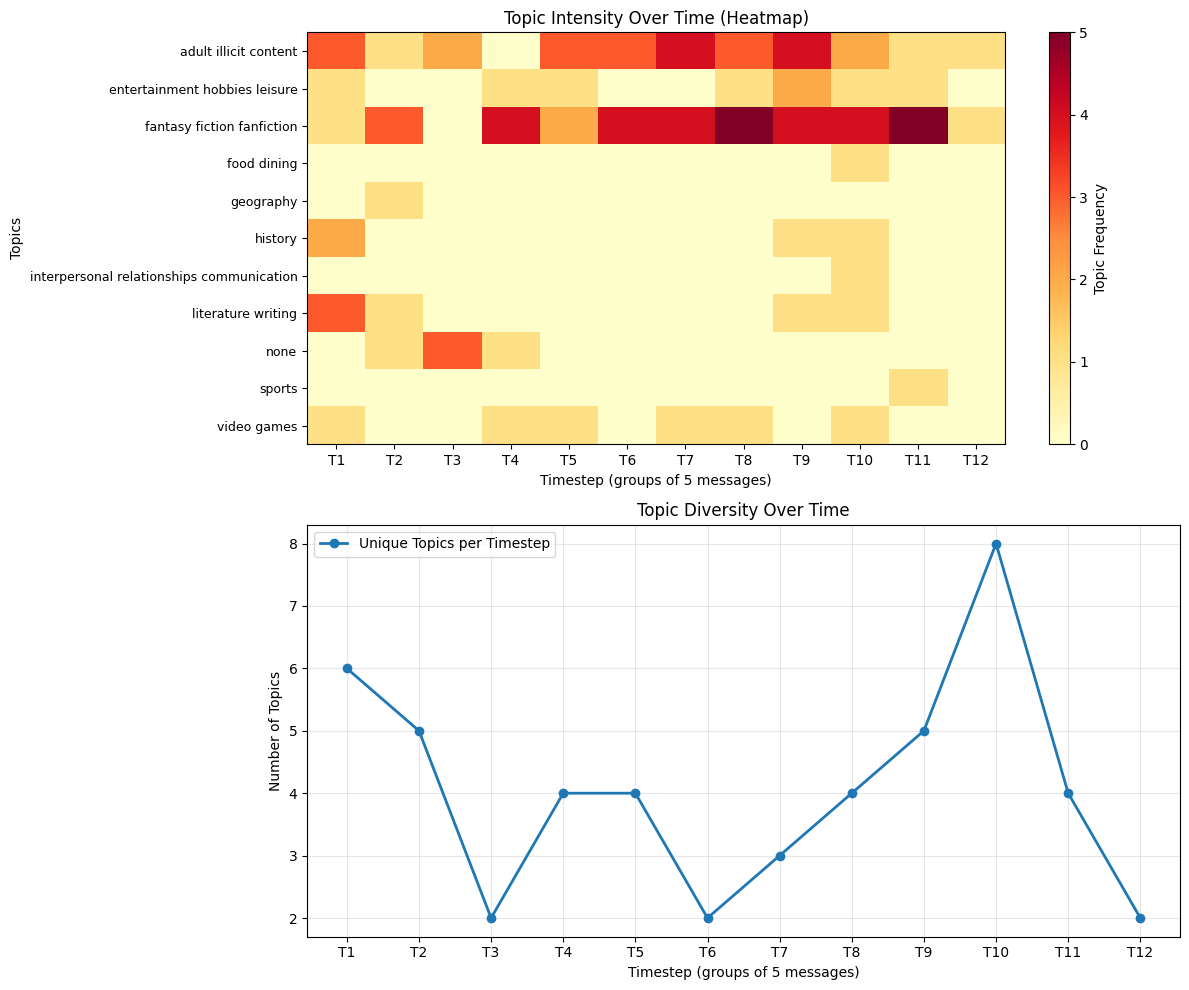

Total messages: 56
Number of timesteps: 12
Messages per timestep: 5
Unique topics across all time: 11

Timestep breakdown:
  Timestep 1: 6 unique topics
    Topics: ['literature writing', 'fantasy fiction fanfiction', 'entertainment hobbies leisure', 'adult illicit content', 'video games', 'history']
  Timestep 2: 5 unique topics
    Topics: ['literature writing', 'fantasy fiction fanfiction', 'adult illicit content', 'geography', 'none']
  Timestep 3: 2 unique topics
    Topics: ['adult illicit content', 'none']
  Timestep 4: 4 unique topics
    Topics: ['fantasy fiction fanfiction', 'none', 'entertainment hobbies leisure', 'video games']
  Timestep 5: 4 unique topics
    Topics: ['fantasy fiction fanfiction', 'adult illicit content', 'entertainment hobbies leisure', 'video games']
  Timestep 6: 2 unique topics
    Topics: ['fantasy fiction fanfiction', 'adult illicit content']
  Timestep 7: 3 unique topics
    Topics: ['fantasy fiction fanfiction', 'adult illicit content', 'video gam

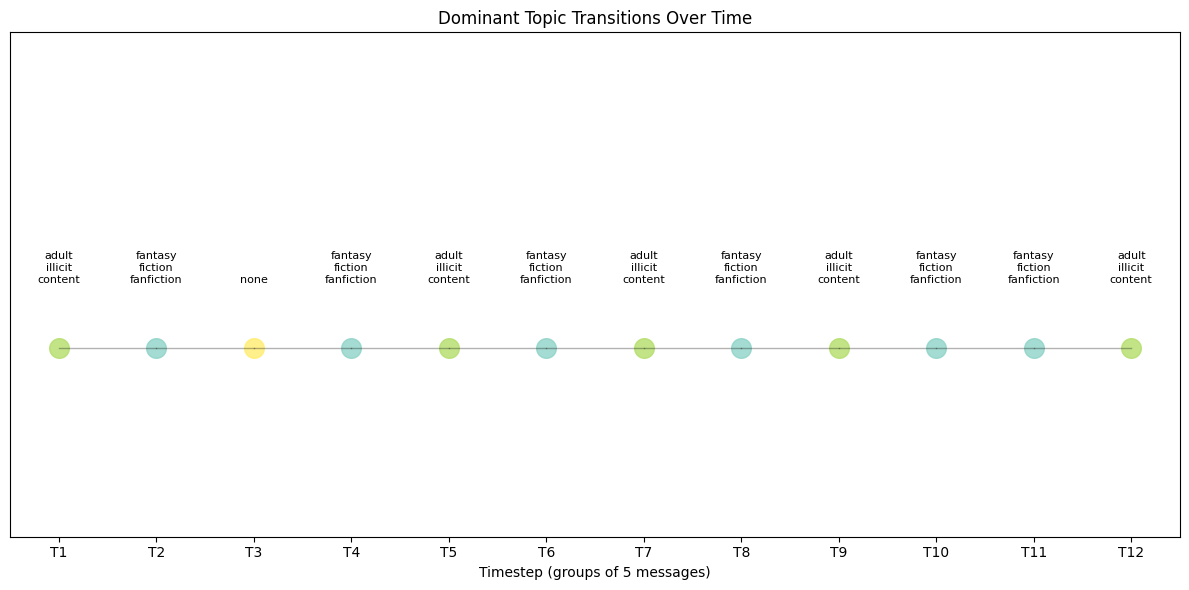

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns

# Sample data (replace with your actual topics list)

def plot_topic_changes(topics, messages_per_timestep=5):
    """
    Plot how user's topics change over time by grouping messages into timesteps.
    
    Args:
        topics: List of lists, where each inner list contains topics for one message
        messages_per_timestep: Number of messages to group into each timestep
    """
    
    # Group messages into timesteps
    timesteps = []
    for i in range(0, len(topics), messages_per_timestep):
        timestep_topics = []
        for j in range(i, min(i + messages_per_timestep, len(topics))):
            timestep_topics.extend(topics[j])  # Flatten topics from all messages in this timestep
        timesteps.append(timestep_topics)
    
    # Get all unique topics across all timesteps
    all_topics = set()
    for timestep in timesteps:
        all_topics.update(timestep)
    all_topics = sorted(list(all_topics))
    
    # Create a matrix showing topic frequency at each timestep
    topic_matrix = np.zeros((len(all_topics), len(timesteps)))
    
    for t_idx, timestep in enumerate(timesteps):
        topic_counts = Counter(timestep)
        for topic_idx, topic in enumerate(all_topics):
            topic_matrix[topic_idx, t_idx] = topic_counts.get(topic, 0)
    
    # Create the visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Heatmap showing topic intensity over time
    im = ax1.imshow(topic_matrix, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    ax1.set_yticks(range(len(all_topics)))
    ax1.set_yticklabels(all_topics, fontsize=9)
    ax1.set_xticks(range(len(timesteps)))
    ax1.set_xticklabels([f'T{i+1}' for i in range(len(timesteps))])
    ax1.set_xlabel('Timestep (groups of 5 messages)')
    ax1.set_ylabel('Topics')
    ax1.set_title('Topic Intensity Over Time (Heatmap)')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax1)
    cbar.set_label('Topic Frequency')
    
    # Plot 2: Line plot showing topic diversity over time
    topic_diversity = [len(set(timestep)) for timestep in timesteps]
    total_topics = [len(timestep) for timestep in timesteps]
    
    ax2.plot(range(len(timesteps)), topic_diversity, 'o-', label='Unique Topics per Timestep', linewidth=2)
    ax2.set_xlabel('Timestep (groups of 5 messages)')
    ax2.set_ylabel('Number of Topics')
    ax2.set_title('Topic Diversity Over Time')
    ax2.set_xticks(range(len(timesteps)))
    ax2.set_xticklabels([f'T{i+1}' for i in range(len(timesteps))])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Total messages: {len(topics)}")
    print(f"Number of timesteps: {len(timesteps)}")
    print(f"Messages per timestep: {messages_per_timestep}")
    print(f"Unique topics across all time: {len(all_topics)}")
    print("\nTimestep breakdown:")
    for i, timestep in enumerate(timesteps):
        unique_topics = len(set(timestep))
        print(f"  Timestep {i+1}: {unique_topics} unique topics")
        print(f"    Topics: {list(set(timestep))}")

def plot_topic_transitions(topics, messages_per_timestep=5):
    """
    Additional visualization showing topic transitions between timesteps.
    """
    # Group messages into timesteps and get dominant topic for each
    timestep_dominant_topics = []
    for i in range(0, len(topics), messages_per_timestep):
        timestep_topics = []
        for j in range(i, min(i + messages_per_timestep, len(topics))):
            timestep_topics.extend(topics[j])
        
        if timestep_topics:
            # Get most common topic in this timestep
            dominant_topic = Counter(timestep_topics).most_common(1)[0][0]
            timestep_dominant_topics.append(dominant_topic)
    
    # Create transition visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot dominant topic changes
    topic_colors = {}
    unique_topics = list(set(timestep_dominant_topics))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_topics)))
    
    for i, topic in enumerate(unique_topics):
        topic_colors[topic] = colors[i]
    
    for i, topic in enumerate(timestep_dominant_topics):
        ax.scatter(i, 0, s=200, c=[topic_colors[topic]], alpha=0.8)
        ax.text(i, 0.1, topic.replace(' ', '\n'), ha='center', va='bottom', fontsize=8, rotation=0)
    
    ax.set_xlim(-0.5, len(timestep_dominant_topics) - 0.5)
    ax.set_ylim(-0.3, 0.5)
    ax.set_xlabel('Timestep (groups of 5 messages)')
    ax.set_title('Dominant Topic Transitions Over Time')
    ax.set_xticks(range(len(timestep_dominant_topics)))
    ax.set_xticklabels([f'T{i+1}' for i in range(len(timestep_dominant_topics))])
    ax.set_yticks([])
    
    # Add lines connecting transitions
    for i in range(len(timestep_dominant_topics) - 1):
        ax.plot([i, i+1], [0, 0], 'k-', alpha=0.3, linewidth=1)
    
    plt.tight_layout()
    plt.show()

# Run the visualizations
plot_topic_changes(topics)
plot_topic_transitions(topics)

## Distribution of users by topic count
### Long-tail distribution, with most users having a small number of conversations
### Distribution of users by topic count in 2024 and 2025 shows consistent patterns
### Distribution of users by topic count (normalized by conversation count): since most users have few recorded conversations, the majority is 1

In [18]:
topics_distribution = {}

for conv in dataset.data:
    user_id = conv.user_id
    topic_count = 0
    for message in conv.conversation:
        if "automatic_v0-turn_topic" in message.metadata.keys():
            topic_count += 1
    if user_id not in topics_distribution:
        topics_distribution[user_id] = topic_count
    else:
        topics_distribution[user_id] += topic_count  # in case user_id appears in multiple convs

print(topics_distribution)

{'8fe04885ac7d4510a0f7695261f3285dff4529ce91d15f84dc6c5880977a556a': 10, 'fa795c0023cd320f502366592ffcf73666a86c9eca161387ece66eec1fe8514a': 2, '3cc9823b60008e82cad53972055bef7ee9900bae7e4dfb14e15e293f05a69dd6': 1, 'e483d078a0a90f7684f9950c45a370dfcf70ccdcc792cdbf1756e1fd38ab544c': 2, 'c1dd4cf7cd5e49b5a23e3a135ad7e445b2ad0351807525b2ef25cbdd40b584f8': 1, '9ea6d561a74c568b3de8c2559fa6809fdd1e60cb858f08d07e0c1e0527d4d47c': 5, 'cb0338307c204b84305debd3b17f16ea0da5f54a29be74cf8e232f63e0386a8b': 1, '2ccbf1367575a6c36703fa7095cfe6b6e424983b85e61333ba5c6f6078fd2cf6': 2, '47c8ed61cf1f13af567136a8b8bf7e0434d824e5a6e9633e4db16c97c6b6b521': 1, 'e2e91c20c4191837c72adf0c5284edabbf6f52317ba948dd4ca00c80badc02fb': 5, '9f6bbe7a5f031d521861999b8cee963202488504ed32279c7ba105dc5fb44be6': 2, 'ef89468aa4572dd07d6a0cca7f49ec85874afa49c9b6bb367ef94e1106e8c65d': 4, 'f48dbd9cd788089d2c80f5ba1cf89095ce6ee8cce65a3f43f5a3cfa453689781': 12, '7467776153377b6a5347d67868dd991dcda2636a3a721ff87e8764829c1621c6': 4, 'de

{'8fe04885ac7d4510a0f7695261f3285dff4529ce91d15f84dc6c5880977a556a': 9, 'fa795c0023cd320f502366592ffcf73666a86c9eca161387ece66eec1fe8514a': 1, '3cc9823b60008e82cad53972055bef7ee9900bae7e4dfb14e15e293f05a69dd6': 1, 'e483d078a0a90f7684f9950c45a370dfcf70ccdcc792cdbf1756e1fd38ab544c': 1, 'c1dd4cf7cd5e49b5a23e3a135ad7e445b2ad0351807525b2ef25cbdd40b584f8': 1, '9ea6d561a74c568b3de8c2559fa6809fdd1e60cb858f08d07e0c1e0527d4d47c': 3, 'cb0338307c204b84305debd3b17f16ea0da5f54a29be74cf8e232f63e0386a8b': 4, '2ccbf1367575a6c36703fa7095cfe6b6e424983b85e61333ba5c6f6078fd2cf6': 2, '47c8ed61cf1f13af567136a8b8bf7e0434d824e5a6e9633e4db16c97c6b6b521': 1, 'e2e91c20c4191837c72adf0c5284edabbf6f52317ba948dd4ca00c80badc02fb': 9, '9f6bbe7a5f031d521861999b8cee963202488504ed32279c7ba105dc5fb44be6': 3, 'ef89468aa4572dd07d6a0cca7f49ec85874afa49c9b6bb367ef94e1106e8c65d': 1, 'f48dbd9cd788089d2c80f5ba1cf89095ce6ee8cce65a3f43f5a3cfa453689781': 7, '7467776153377b6a5347d67868dd991dcda2636a3a721ff87e8764829c1621c6': 1, 'de84

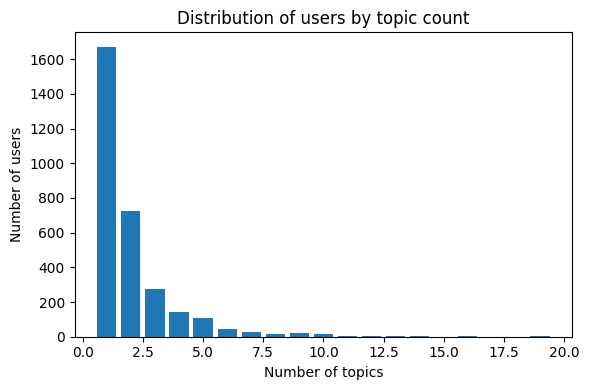

In [35]:
from collections import defaultdict

# 1) Collect all topics per user (as a list)
topics_per_user = defaultdict(list)

for conv in dataset.data:
    user_id = conv.user_id
    for message in conv.conversation:
        if "automatic_v0-turn_topic" in message.metadata.keys():
            val = message.metadata["automatic_v0-turn_topic"].value
            vals = val if isinstance(val, (list, tuple, set)) else [val]
            for v in vals:
                if v is not None:
                    topics_per_user[user_id].append(str(v))

# 2) Count unique topics per user
topics_distribution = {uid: len(set(topics)) for uid, topics in topics_per_user.items()}

print(topics_distribution)

import matplotlib.pyplot as plt
from collections import Counter

count_dist = Counter(topics_distribution.values())
xs = sorted(count_dist.keys())
ys = [count_dist[x] for x in xs]

plt.figure(figsize=(6, 4))
plt.bar(xs, ys)
plt.xlabel("Number of topics")
plt.ylabel("Number of users")
plt.title("Distribution of users by topic count")
plt.tight_layout()
plt.show()


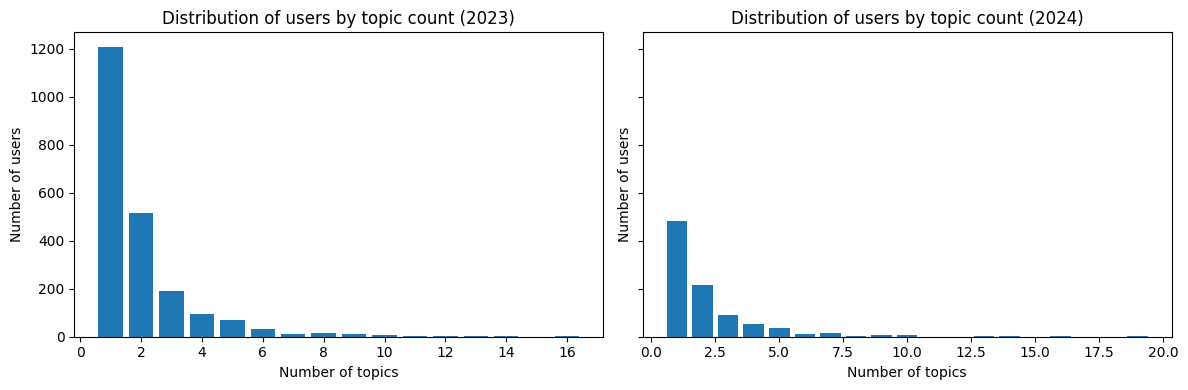

In [42]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# 1) Collect all topics per user per year
topics_per_user_year = defaultdict(lambda: defaultdict(list))

for conv in dataset.data:
    user_id = conv.user_id
    year = conv.time[:4]
    for message in conv.conversation:
        if "automatic_v0-turn_topic" in message.metadata.keys():
            val = message.metadata["automatic_v0-turn_topic"].value
            vals = val if isinstance(val, (list, tuple, set)) else [val]
            for v in vals:
                if v is not None:
                    topics_per_user_year[year][user_id].append(str(v))

# 2) Count unique topics per user for each year
topics_distribution_year = {
    year: {uid: len(set(topics)) for uid, topics in users.items()}
    for year, users in topics_per_user_year.items()
}

# 3) Plot distributions for 2023 and 2024
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for ax, year in zip(axes, ["2023", "2024"]):
    if year in topics_distribution_year:
        count_dist = Counter(topics_distribution_year[year].values())
        xs = sorted(count_dist.keys())
        ys = [count_dist[x] for x in xs]
        ax.bar(xs, ys)
        ax.set_xlabel("Number of topics")
        ax.set_ylabel("Number of users")
        ax.set_title(f"Distribution of users by topic count ({year})")
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()

{'8fe04885ac7d4510a0f7695261f3285dff4529ce91d15f84dc6c5880977a556a': 0.6428571428571429, 'fa795c0023cd320f502366592ffcf73666a86c9eca161387ece66eec1fe8514a': 0.5, '3cc9823b60008e82cad53972055bef7ee9900bae7e4dfb14e15e293f05a69dd6': 1.0, 'e483d078a0a90f7684f9950c45a370dfcf70ccdcc792cdbf1756e1fd38ab544c': 0.5, 'c1dd4cf7cd5e49b5a23e3a135ad7e445b2ad0351807525b2ef25cbdd40b584f8': 1.0, '9ea6d561a74c568b3de8c2559fa6809fdd1e60cb858f08d07e0c1e0527d4d47c': 0.375, 'cb0338307c204b84305debd3b17f16ea0da5f54a29be74cf8e232f63e0386a8b': 1.0, '2ccbf1367575a6c36703fa7095cfe6b6e424983b85e61333ba5c6f6078fd2cf6': 0.6666666666666666, '47c8ed61cf1f13af567136a8b8bf7e0434d824e5a6e9633e4db16c97c6b6b521': 1.0, 'e2e91c20c4191837c72adf0c5284edabbf6f52317ba948dd4ca00c80badc02fb': 0.8181818181818182, '9f6bbe7a5f031d521861999b8cee963202488504ed32279c7ba105dc5fb44be6': 0.75, 'ef89468aa4572dd07d6a0cca7f49ec85874afa49c9b6bb367ef94e1106e8c65d': 0.25, 'f48dbd9cd788089d2c80f5ba1cf89095ce6ee8cce65a3f43f5a3cfa453689781': 0.5833

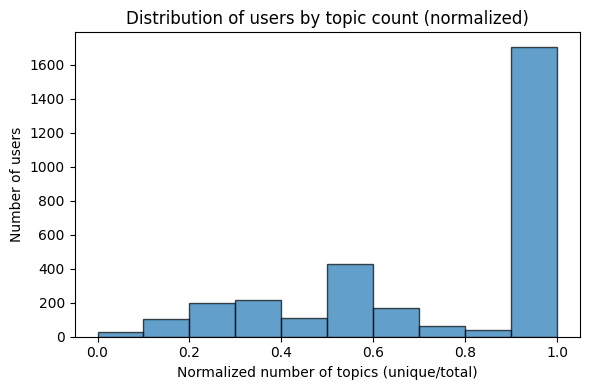

In [ ]:
topics_distribution_normalized = {uid: len(set(topics)) / len(topics) for uid, topics in topics_per_user.items()}

print(topics_distribution_normalized)

values = list(topics_distribution_normalized.values())

# Plot histogram with better binning
plt.figure(figsize=(6, 4))
plt.hist(values, bins=np.linspace(0, 1, 11), edgecolor="black", alpha=0.7)
plt.xlabel("Normalized number of topics (unique/total)")
plt.ylabel("Number of users")
plt.title("Distribution of users by topic count (normalized)")
plt.tight_layout()
plt.show()